In [39]:
pip install pandas matplotlib seaborn psycopg2


Note: you may need to restart the kernel to use updated packages.


In [261]:
from sqlalchemy import create_engine
import pandas as pd

# Veritabanı bağlantısı için gerekli bilgiler
DB_HOST = 'localhost'
DB_PORT = '5432'
DB_NAME = 'capstone1'
DB_USER = 'postgres'
DB_PASS = 'Em030315'

# SQLAlchemy engine oluşturma
database_uri = f'postgresql+psycopg2://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}'
engine = create_engine(database_uri)

# Veritabanına bağlanma ve verileri çekme
def get_data_from_db(query):
    try:
        # SQL sorgusunu çalıştırma ve verileri DataFrame olarak çekme
        df = pd.read_sql(query, engine)
        return df
    except Exception as e:
        print(f"Error: {e}")


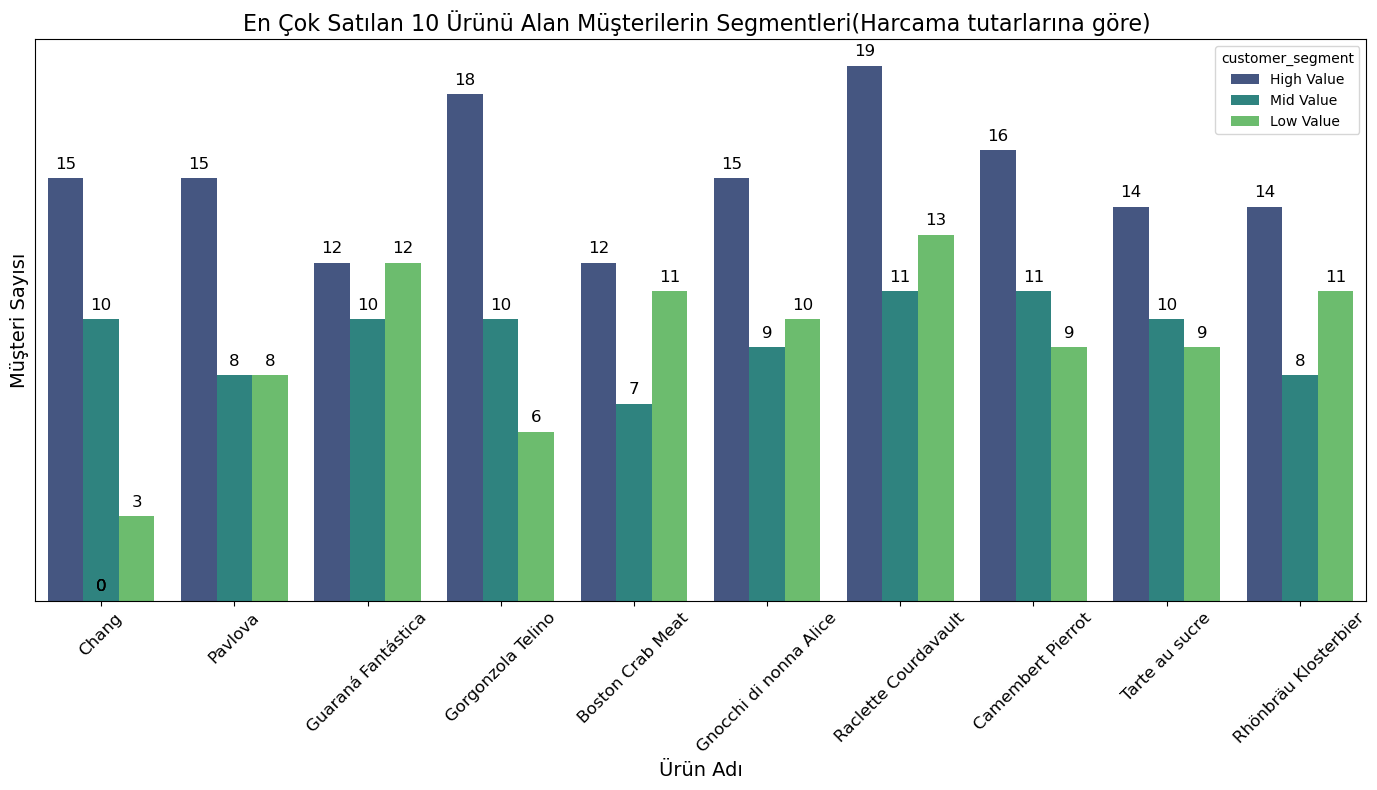

In [263]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine, text

# Veritabanı bağlantısı için gerekli bilgiler
DB_HOST = 'localhost'
DB_PORT = '5432'
DB_NAME = 'capstone1'
DB_USER = 'postgres'
DB_PASS = 'Em030315'

# SQLAlchemy engine oluşturma
database_uri = f'postgresql+psycopg2://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}'
engine = create_engine(database_uri)

# SQL sorgusu ile verileri çekme ve segmentasyon
query = """
WITH top_products AS (
    SELECT
        p.product_id,
        p.product_name,
        SUM(od.quantity) AS total_quantity
    FROM
        order_details od
        JOIN products p ON od.product_id = p.product_id
    GROUP BY
        p.product_id, p.product_name
    ORDER BY
        total_quantity DESC
    LIMIT 10
),
customer_purchases AS (
    SELECT
        c.customer_id,
        c.company_name,
        p.product_id,
        p.product_name,
        SUM(od.unit_price * od.quantity) AS total_amount
    FROM
        customers c
        JOIN orders o ON c.customer_id = o.customer_id
        JOIN order_details od ON o.order_id = od.order_id
        JOIN top_products p ON od.product_id = p.product_id
    GROUP BY
        c.customer_id, c.company_name, p.product_id, p.product_name
),
total_spent AS (
    SELECT
        customer_id,
        company_name,
        SUM(total_amount) AS total_spent
    FROM
        customer_purchases
    GROUP BY
        customer_id, company_name
)
SELECT
    cp.customer_id,
    cp.company_name,
    cp.product_id,
    cp.product_name,
    cp.total_amount,
    ts.total_spent,
    CASE
        WHEN ts.total_spent >= (SELECT PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY total_spent) FROM total_spent) THEN 'High Value'
        WHEN ts.total_spent >= (SELECT PERCENTILE_CONT(0.50) WITHIN GROUP (ORDER BY total_spent) FROM total_spent) THEN 'Mid Value'
        ELSE 'Low Value'
    END AS customer_segment
FROM
    customer_purchases cp
    JOIN total_spent ts ON cp.customer_id = ts.customer_id
ORDER BY
    cp.product_id, cp.total_amount DESC;
"""

# Sorguyu çalıştırma ve sonucu pandas DataFrame'e yükleme
with engine.connect() as conn:
    df = pd.read_sql_query(text(query), conn)

# Görselleştirme
plt.figure(figsize=(14, 8))
ax = sns.countplot(data=df, x='product_name', hue='customer_segment', palette='viridis')
plt.xlabel('Ürün Adı', fontsize=14)
plt.ylabel('Müşteri Sayısı', fontsize=14)
plt.title('En Çok Satılan 10 Ürünü Alan Müşterilerin Segmentleri(Harcama tutarlarına göre) ', fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.yticks([])  # Y eksenindeki sayıları kaldırmak için

# Barların üzerindeki değerleri gösterme
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
               (p.get_x() + p.get_width() / 2., p.get_height()), 
               ha = 'center', va = 'center', 
               xytext = (0, 10), 
               textcoords = 'offset points',
               fontsize=12)

plt.tight_layout()
plt.show()




In [271]:
print("""
Satış Müdürü, hangi ürünlerin en çok satıldığını ve bu ürünleri en çok hangi müşteri segmentlerinin satın aldığını bilmek istiyor. Bu bilgiler, 
gelecekteki pazarlama stratejilerini belirlemek için kullanılacak.

Grafik Yorumu ve İçgörüler
Bu grafik, en çok satılan 10 ürünü alan müşterilerin segmentlere göre dağılımını gösterir. Segmentler, müşterilerin harcama tutarlarına göre 
"High Value", "Mid Value" ve "Low Value" olarak kategorize edilmiştir. İşte bu grafiği kullanarak gelecekteki pazarlama stratejilerini belirlemek 
için bazı içgörüler ve öneriler:

1. Yüksek Değerli Müşterilere (High Value) Odaklanma:
Yüksek Değerli Müşteriler: "Chang", "Pavlova", "Guaraná Fantástica", "Gorgonzola Telino", "Boston Crab Meat", "Gnocchi di nonna Alice", 
"Raclette Courdavault", "Camembert Pierrot", "Tarte au sucre" ve "Rhönbräu Klosterbier" gibi ürünleri alan müşterilerin büyük bir kısmı 
"High Value" segmentinde yer alıyor.
Öneri: Bu ürünler için sadakat programları, özel teklifler ve premium hizmetler sunarak bu yüksek değerli müşterileri elde tutmayı hedefleyin.
Bu müşteriler genellikle daha fazla harcama yapar ve markanıza daha sadıktır.

2. Orta Değerli Müşterileri (Mid Value) Teşvik Etme:
Orta Değerli Müşteriler: "Gorgonzola Telino" ve "Raclette Courdavault" gibi ürünlerde orta değerli müşterilerin sayısı belirgin bir şekilde 
görülmektedir.
Öneri: Orta değerli müşterileri, yüksek değerli müşteri segmentine dönüştürmek için çapraz satış ve yukarı satış (upsell) stratejileri 
kullanabilirsiniz. Bu müşterilere özel indirimler, paket teklifleri veya ödül programları sunarak harcamalarını artırabilirsiniz.

3. Düşük Değerli Müşterileri (Low Value) Elde Tutma:
Düşük Değerli Müşteriler: Grafikte düşük değerli müşterilerin sayısı diğer segmentlere göre daha azdır.
Öneri: Bu müşterileri elde tutmak için düşük maliyetli teşvikler sunabilirsiniz. Örneğin, ücretsiz kargo, ilk alışverişte indirim veya küçük 
hediyeler gibi teşvikler düşük değerli müşterilerin sadakatini artırabilir.

4. Ürün Bazlı Stratejiler:
Çok Satılan Ürünler: "Chang" ve "Gnocchi di nonna Alice" gibi ürünler, tüm segmentlerde yüksek talep görmektedir. Bu ürünler için stok seviyelerini 
yüksek tutarak, tedarik zinciri yönetimini optimize edebilirsiniz.
Öneri: Bu popüler ürünler için özel kampanyalar düzenleyerek daha fazla müşteri çekebilir ve mevcut müşterilerinizi tekrar alışveriş yapmaya teşvik 
edebilirsiniz.

5. Segmentlere Özel Pazarlama Kampanyaları:
Segment Bazlı Kampanyalar: Her segment için özelleştirilmiş pazarlama kampanyaları oluşturun. Örneğin, yüksek değerli müşterilere VIP etkinlik
davetiyeleri gönderirken, orta değerli müşterilere çapraz satış teklifleri sunabilirsiniz.
Öneri: Pazarlama kampanyalarını segmentlere göre özelleştirerek, her segmentin ihtiyaçlarına ve harcama alışkanlıklarına uygun stratejiler 
geliştirin. Bu, müşteri memnuniyetini artırabilir ve uzun vadeli sadakat oluşturabilir.

Sonuç
Bu grafik, müşterilerin segmentlerine göre harcama alışkanlıklarını ve tercih ettikleri ürünleri anlamak için önemli bir araçtır. Yukarıdaki 
içgörüler ve stratejiler, müşteri segmentlerine uygun pazarlama kampanyaları oluşturmanıza ve müşteri sadakatini artırmanıza yardımcı olabilir. 
Bu analizler, gelecekteki pazarlama stratejilerinizi daha etkili ve hedefli hale getirebilir.
""")



Satış Müdürü, hangi ürünlerin en çok satıldığını ve bu ürünleri en çok hangi müşteri segmentlerinin satın aldığını bilmek istiyor. Bu bilgiler, 
gelecekteki pazarlama stratejilerini belirlemek için kullanılacak.

Grafik Yorumu ve İçgörüler
Bu grafik, en çok satılan 10 ürünü alan müşterilerin segmentlere göre dağılımını gösterir. Segmentler, müşterilerin harcama tutarlarına göre 
"High Value", "Mid Value" ve "Low Value" olarak kategorize edilmiştir. İşte bu grafiği kullanarak gelecekteki pazarlama stratejilerini belirlemek 
için bazı içgörüler ve öneriler:

1. Yüksek Değerli Müşterilere (High Value) Odaklanma:
Yüksek Değerli Müşteriler: "Chang", "Pavlova", "Guaraná Fantástica", "Gorgonzola Telino", "Boston Crab Meat", "Gnocchi di nonna Alice", 
"Raclette Courdavault", "Camembert Pierrot", "Tarte au sucre" ve "Rhönbräu Klosterbier" gibi ürünleri alan müşterilerin büyük bir kısmı 
"High Value" segmentinde yer alıyor.
Öneri: Bu ürünler için sadakat programları, özel teklifler ve premium h

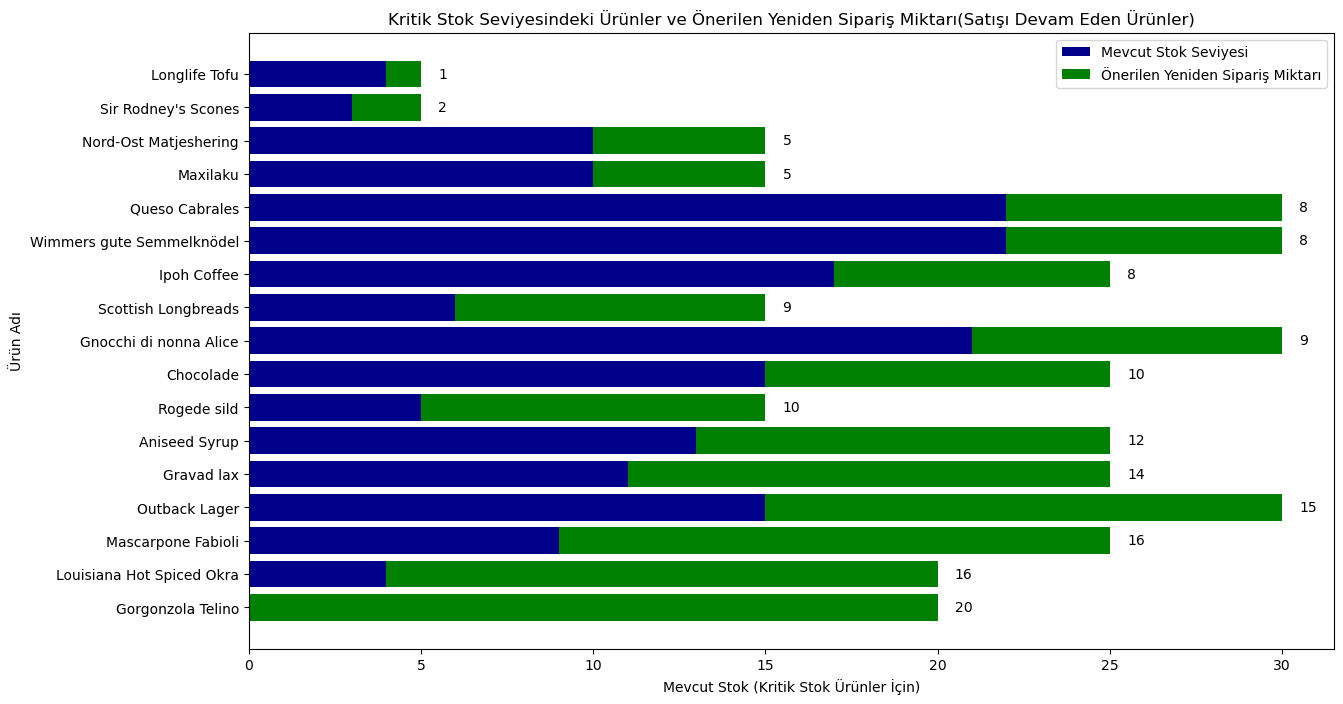

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

# Veritabanı bağlantısı için gerekli bilgiler
DB_HOST = 'localhost'
DB_PORT = '5432'
DB_NAME = 'capstone1'
DB_USER = 'postgres'
DB_PASS = 'Em030315'

# SQLAlchemy engine oluşturma
database_uri = f'postgresql+psycopg2://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}'
engine = create_engine(database_uri)

# SQL sorgusu
query = """
WITH critical_stock AS (
    SELECT 
        product_id,
        product_name,
        unit_in_stock,
        reorder_level,
        CASE 
            WHEN unit_in_stock < reorder_level THEN reorder_level - unit_in_stock
            ELSE 0
        END AS reorder_quantity
    FROM 
        products
    WHERE 
        unit_in_stock <= reorder_level
        AND discontinued = 0
)
SELECT 
    product_id,
    product_name,
    unit_in_stock,
    reorder_level,
    reorder_quantity
FROM 
    critical_stock
ORDER BY
    reorder_quantity DESC;
"""

# Verileri çekme
with engine.connect() as conn:
    critical_stock_data = pd.read_sql_query(query, conn)

# Yatay çubuk grafik ile görselleştirme
plt.figure(figsize=(14, 8))

# Mevcut stok seviyeleri
plt.barh(critical_stock_data['product_name'], critical_stock_data['unit_in_stock'], color='darkblue', label='Mevcut Stok Seviyesi')

# Önerilen yeniden sipariş miktarları
plt.barh(critical_stock_data['product_name'], critical_stock_data['reorder_quantity'], color='green', left=critical_stock_data['unit_in_stock'], label='Önerilen Yeniden Sipariş Miktarı')

plt.xlabel('Mevcut Stok (Kritik Stok Ürünler İçin)')
plt.ylabel('Ürün Adı')
plt.title('Kritik Stok Seviyesindeki Ürünler ve Önerilen Yeniden Sipariş Miktarı(Satışı Devam Eden Ürünler)')
plt.legend()

# Değer etiketlerini ekleme
for index, value in enumerate(critical_stock_data['reorder_quantity']):
    plt.text(critical_stock_data['unit_in_stock'][index] + value + 0.5, index, str(value), va='center')

plt.show()


In [56]:

print("""Depo Müdürü, hangi ürünlerin stok seviyelerinin kritik düzeyde olduğunu ve yeniden sipariş verilmesi gerektiğini bilmek istiyor. 
Amaç, stok dışı kalma durumlarını önlemek ve tedarik zincirini optimize etmek.

Grafik Yorumu ve İçgörüler
Bu grafik, kritik stok seviyesindeki ürünlerin mevcut stok seviyelerini ve önerilen yeniden sipariş miktarlarını göstermektedir. Bu grafik, stok dışı kalma durumlarını önlemek ve tedarik zincirini optimize etmek amacıyla kullanılabilir. İşte bu grafiği kullanarak gelecekteki stratejilerinizi belirlemek için bazı içgörüler ve öneriler:

1. Kriti̇k Ürünler ve Önceli̇kli̇ Si̇pari̇şler:
   - Gorgonzola Telino: Bu ürün, mevcut stok seviyesi sıfır olan ve en yüksek yeniden sipariş miktarına sahip üründür (20 adet). Bu ürün acil olarak sipariş verilmelidir.
   - Louisiana Hot Spiced Okra: Mevcut stok seviyesi düşük (4 adet) ve yeniden sipariş miktarı yüksek (16 adet). Bu ürün de acil sipariş gerektirir.
   - Mascarpone Fabioli ve Outback Lager: Her iki ürünün de stok seviyeleri sıfır ve yeniden sipariş miktarları yüksek (15-16 adet). Bu ürünler de öncelikli sipariş verilmesi gereken ürünler arasında yer alır.

2. Orta Düzeyde Kriti̇k Ürünler:
   - Gravad Lax, Rogede Sild, ve Chocolate: Bu ürünler için stok seviyeleri düşük ve yeniden sipariş miktarları orta düzeydedir (9-14 adet). Bu ürünler de takip edilerek stok seviyeleri artırılmalıdır.

3. Düşük Stok Seviyeleri ve Daha Az Yeniden Sipariş Gerektiren Ürünler:
   - Sir Rodney's Scones, Longlife Tofu: Mevcut stok seviyeleri düşük (1-2 adet) ve yeniden sipariş miktarları da nispeten düşüktür (2-5 adet). Bu ürünler için de dikkatli olunmalı ancak acil sipariş gerektirmeyebilir.

Öneriler:
1. Acil Sipariş Verilmesi Gereken Ürünler:
   - Gorgonzola Telino, Louisiana Hot Spiced Okra, Mascarpone Fabioli ve Outback Lager ürünleri için acil sipariş verilmeli ve stok seviyeleri artırılmalıdır. Bu ürünlerin tedarik zincirinde aksama olmaması için düzenli olarak stok seviyeleri izlenmelidir.

2. Stok Yönetimi ve Takip:
   - Orta düzeyde kritik olan ürünler (Gravad Lax, Rogede Sild, Chocolate vb.) için düzenli takip yapılmalı ve stok seviyeleri optimize edilmelidir. Bu ürünler için sipariş zamanlaması ve miktarları iyi planlanmalıdır.

3. Tedarik Zinciri Optimizasyonu:
   - Mevcut stok seviyeleri ve yeniden sipariş miktarları dikkatlice izlenerek tedarik zinciri optimize edilmelidir. Stok dışı kalma durumlarını önlemek için talep tahminleri ve sipariş süreleri dikkate alınmalıdır.

4. Stok Takip Sistemi:
   - Etkili bir stok takip sistemi kurarak kritik stok seviyelerini anlık olarak izleyebilir ve gerekli siparişleri zamanında verebilirsiniz. Bu, stok dışı kalma durumlarını minimize eder ve müşteri memnuniyetini artırır.

Bu analiz ve öneriler, şirketin stok yönetimi stratejilerini geliştirmesine ve tedarik zincirini optimize etmesine yardımcı olacaktır. Böylece, stok dışı kalma durumları önlenebilir ve operasyonel verimlilik artırılabilir.
""")




Depo Müdürü, hangi ürünlerin stok seviyelerinin kritik düzeyde olduğunu ve yeniden sipariş verilmesi gerektiğini bilmek istiyor. 
Amaç, stok dışı kalma durumlarını önlemek ve tedarik zincirini optimize etmek.

Grafik Yorumu ve İçgörüler
Bu grafik, kritik stok seviyesindeki ürünlerin mevcut stok seviyelerini ve önerilen yeniden sipariş miktarlarını göstermektedir. Bu grafik, stok dışı kalma durumlarını önlemek ve tedarik zincirini optimize etmek amacıyla kullanılabilir. İşte bu grafiği kullanarak gelecekteki stratejilerinizi belirlemek için bazı içgörüler ve öneriler:

1. Kriti̇k Ürünler ve Önceli̇kli̇ Si̇pari̇şler:
   - Gorgonzola Telino: Bu ürün, mevcut stok seviyesi sıfır olan ve en yüksek yeniden sipariş miktarına sahip üründür (20 adet). Bu ürün acil olarak sipariş verilmelidir.
   - Louisiana Hot Spiced Okra: Mevcut stok seviyesi düşük (4 adet) ve yeniden sipariş miktarı yüksek (16 adet). Bu ürün de acil sipariş gerektirir.
   - Mascarpone Fabioli ve Outback Lager: Her iki ürünün 

In [80]:
pip install sqlalchemy psycopg2 pandas matplotlib seaborn


Note: you may need to restart the kernel to use updated packages.


<Figure size 1400x800 with 0 Axes>

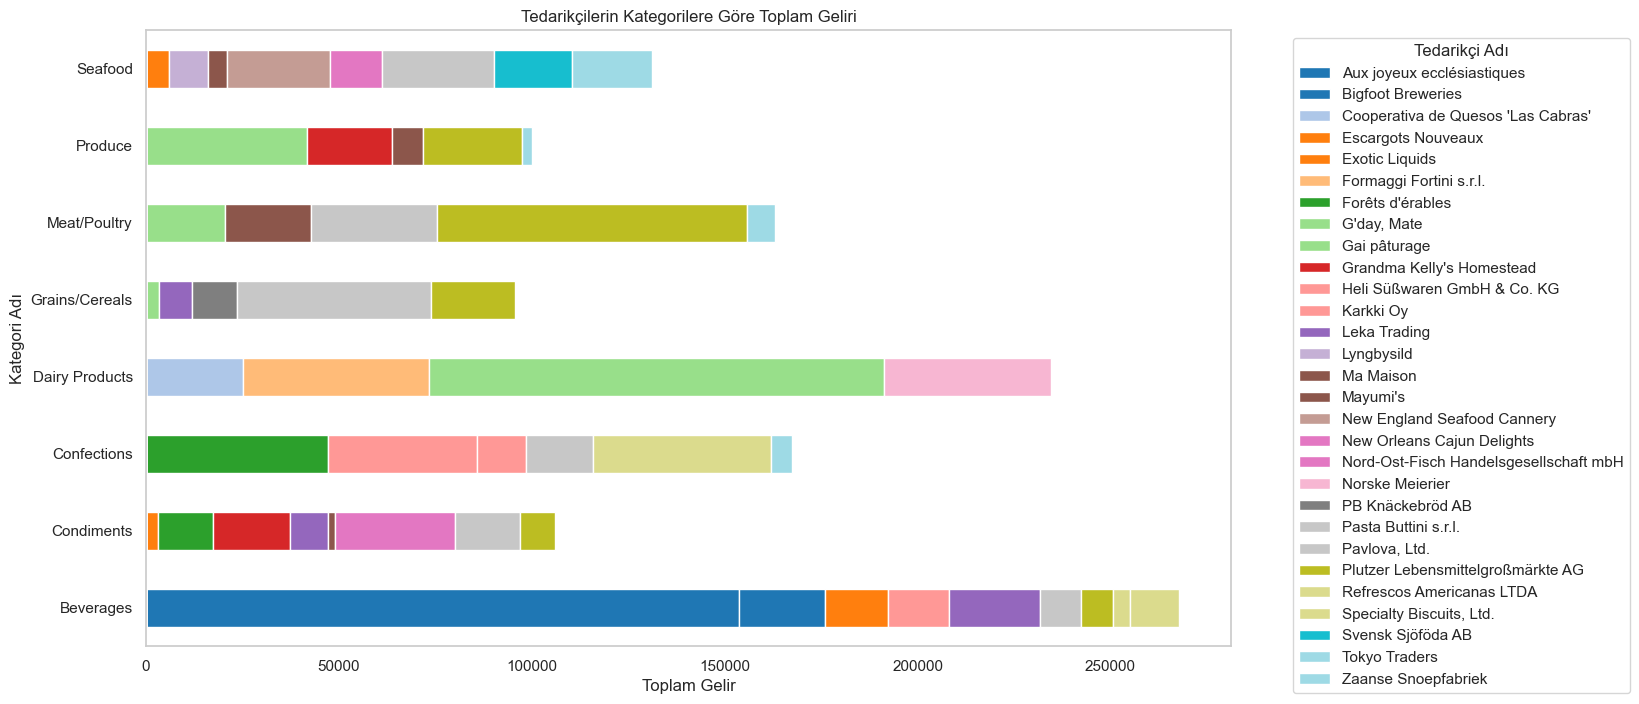

In [84]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine

# Veritabanı bağlantısı için gerekli bilgiler
DB_HOST = 'localhost'
DB_PORT = '5432'
DB_NAME = 'capstone1'
DB_USER = 'postgres'
DB_PASS = 'Em030315'

# SQLAlchemy engine oluşturma
database_uri = f'postgresql+psycopg2://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}'
engine = create_engine(database_uri)

# Veritabanından veriyi çekme
query = """
SELECT
    c.category_name,
    s.company_name,
    SUM(od.unit_price * od.quantity * (1 - od.discount)) AS total_revenue
FROM
    suppliers s
    JOIN products p ON s.supplier_id = p.supplier_id
    JOIN categories c ON p.category_id = c.category_id
    JOIN order_details od ON p.product_id = od.product_id
    JOIN orders o ON od.order_id = o.order_id
GROUP BY
    c.category_name, s.company_name
ORDER BY
    c.category_name, total_revenue DESC;
"""

# Sorguyu çalıştırma ve sonucu pandas DataFrame'e yükleme
with engine.connect() as conn:
    results = pd.read_sql_query(query, conn)

# Veriyi pivotlayarak stacked bar chart için uygun hale getirme
pivot_df = results.pivot(index='category_name', columns='company_name', values='total_revenue').fillna(0)

# Görselleştirme
plt.figure(figsize=(14, 8))
ax = pivot_df.plot(kind='barh', stacked=True, colormap='tab20', figsize=(14, 8))

# Eksen çizgilerini kaldırma
ax.grid(False)

plt.xlabel('Toplam Gelir')
plt.ylabel('Kategori Adı')
plt.title('Tedarikçilerin Kategorilere Göre Toplam Geliri')
plt.legend(title='Tedarikçi Adı', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [88]:
print('''Bu grafik, farklı tedarikçilerin çeşitli ürün kategorilerindeki toplam gelirlerini göstermektedir. Grafik, tedarikçilerin 
kategorilere göre ne kadar gelir elde ettiklerini renkli ve yatay yığınlanmış çubuklar şeklinde görselleştirir. Finans Müdürü'nün amacı, 
hangi tedarikçilerden yapılan alımların en yüksek geliri sağladığını belirleyerek, daha karlı olan tedarikçilerden alım yaparak maliyetleri 
azaltmak ve tedarikçi seçiminde maliyet ve getiri dengesini optimize etmektir.

İçgörüler:
En Yüksek Gelirli Kategoriler ve Tedarikçiler:

Beverages (İçecekler) kategorisi, en yüksek toplam gelire sahip olan kategoridir. Bu kategoride en yüksek gelir elde edilen tedarikçiler:
Aux joyeux ecclésiastiques
Plutzer Lebensmittelgroßmärkte AG
Bigfoot Breweries
Dairy Products (Süt Ürünleri) kategorisinde yüksek gelir elde eden tedarikçiler:
Formaggi Fortini s.r.l.
Norske Meierier
Pavlova, Ltd.
Confections (Şekerlemeler) kategorisinde öne çıkan tedarikçiler:
Gai pâturage
Specialty Biscuits, Ltd.
Kategori Bazlı Tedarikçi Performansı:

Seafood (Deniz Ürünleri) kategorisinde yüksek gelir sağlayan tedarikçiler:
New England Seafood Cannery
Lyngbysild
Escargots Nouveaux
Produce (Meyve/Sebze) kategorisinde:
Cooperativa de Quesos 'Las Cabras'
Exotic Liquids
Meat/Poultry (Et/Tavuk) kategorisinde:
Grandma Kelly's Homestead
Mayumi's

En Karlı Tedarikçiler:

Aux joyeux ecclésiastiques, hemen hemen her kategoride yüksek gelir sağlayan bir tedarikçidir ve toplam gelirde belirgin bir fark yaratır.
Plutzer Lebensmittelgroßmärkte AG, Beverages ve Dairy Products kategorilerinde yüksek gelir elde eden tedarikçiler arasında yer almaktadır.
Öneriler:
Karlılığı Artırma:

Beverages ve Dairy Products kategorilerinde yüksek gelir sağlayan tedarikçilerle ilişkileri güçlendirin ve bu tedarikçilerden daha fazla alım yaparak karlılığı artırın.
Yüksek gelirli tedarikçilere odaklanarak, daha düşük maliyetli ve yüksek karlı alımlar yapın.
Çeşitlendirme ve Risk Yönetimi:

Belirli kategorilerde az sayıda tedarikçi ile çalışılıyorsa, bu kategorilerdeki tedarikçileri çeşitlendirerek riskleri azaltın.
Özellikle yüksek gelirli kategorilerde, yedek tedarikçi bulundurmak tedarik zincirindeki aksamaları minimize edebilir.
Verimlilik ve Tedarikçi İlişkileri:

Gelir getiren tedarikçilerle iş birliğini güçlendirin ve onların ihtiyaçlarını daha iyi anlayarak ilişkileri daha verimli hale getirin.
Düşük gelir getiren kategorilerdeki tedarikçileri gözden geçirerek, performansı düşük olanlarla yolları ayırmayı değerlendirin.
Pazarlama ve Satış Stratejileri:

Yüksek gelirli kategorilere odaklanan pazarlama ve satış stratejileri geliştirin. Bu kategorilerdeki ürünler için daha agresif satış hedefleri belirleyin.
Karlı tedarikçilerden sağlanan ürünlere özel promosyonlar ve kampanyalar düzenleyin.

Sonuç:
Bu grafik, tedarikçilerin hangi kategorilerde daha yüksek gelir sağladığını ve hangi tedarikçilerin daha karlı olduğunu anlamaya yardımcı olur. 
Finans Müdürü, bu bilgiler doğrultusunda tedarik zinciri ve satın alma stratejilerini optimize ederek maliyetleri azaltabilir ve karlılığı 
artırabilir. Tedarikçi performansını ve kategori bazlı gelirleri izleyerek, daha bilinçli ve stratejik kararlar alınabilir.''')

Bu grafik, farklı tedarikçilerin çeşitli ürün kategorilerindeki toplam gelirlerini göstermektedir. Grafik, tedarikçilerin 
kategorilere göre ne kadar gelir elde ettiklerini renkli ve yatay yığınlanmış çubuklar şeklinde görselleştirir. Finans Müdürü'nün amacı, 
hangi tedarikçilerden yapılan alımların en yüksek geliri sağladığını belirleyerek, daha karlı olan tedarikçilerden alım yaparak maliyetleri 
azaltmak ve tedarikçi seçiminde maliyet ve getiri dengesini optimize etmektir.

İçgörüler:
En Yüksek Gelirli Kategoriler ve Tedarikçiler:

Beverages (İçecekler) kategorisi, en yüksek toplam gelire sahip olan kategoridir. Bu kategoride en yüksek gelir elde edilen tedarikçiler:
Aux joyeux ecclésiastiques
Plutzer Lebensmittelgroßmärkte AG
Bigfoot Breweries
Dairy Products (Süt Ürünleri) kategorisinde yüksek gelir elde eden tedarikçiler:
Formaggi Fortini s.r.l.
Norske Meierier
Pavlova, Ltd.
Confections (Şekerlemeler) kategorisinde öne çıkan tedarikçiler:
Gai pâturage
Specialty Biscuits, Ltd.
Kate

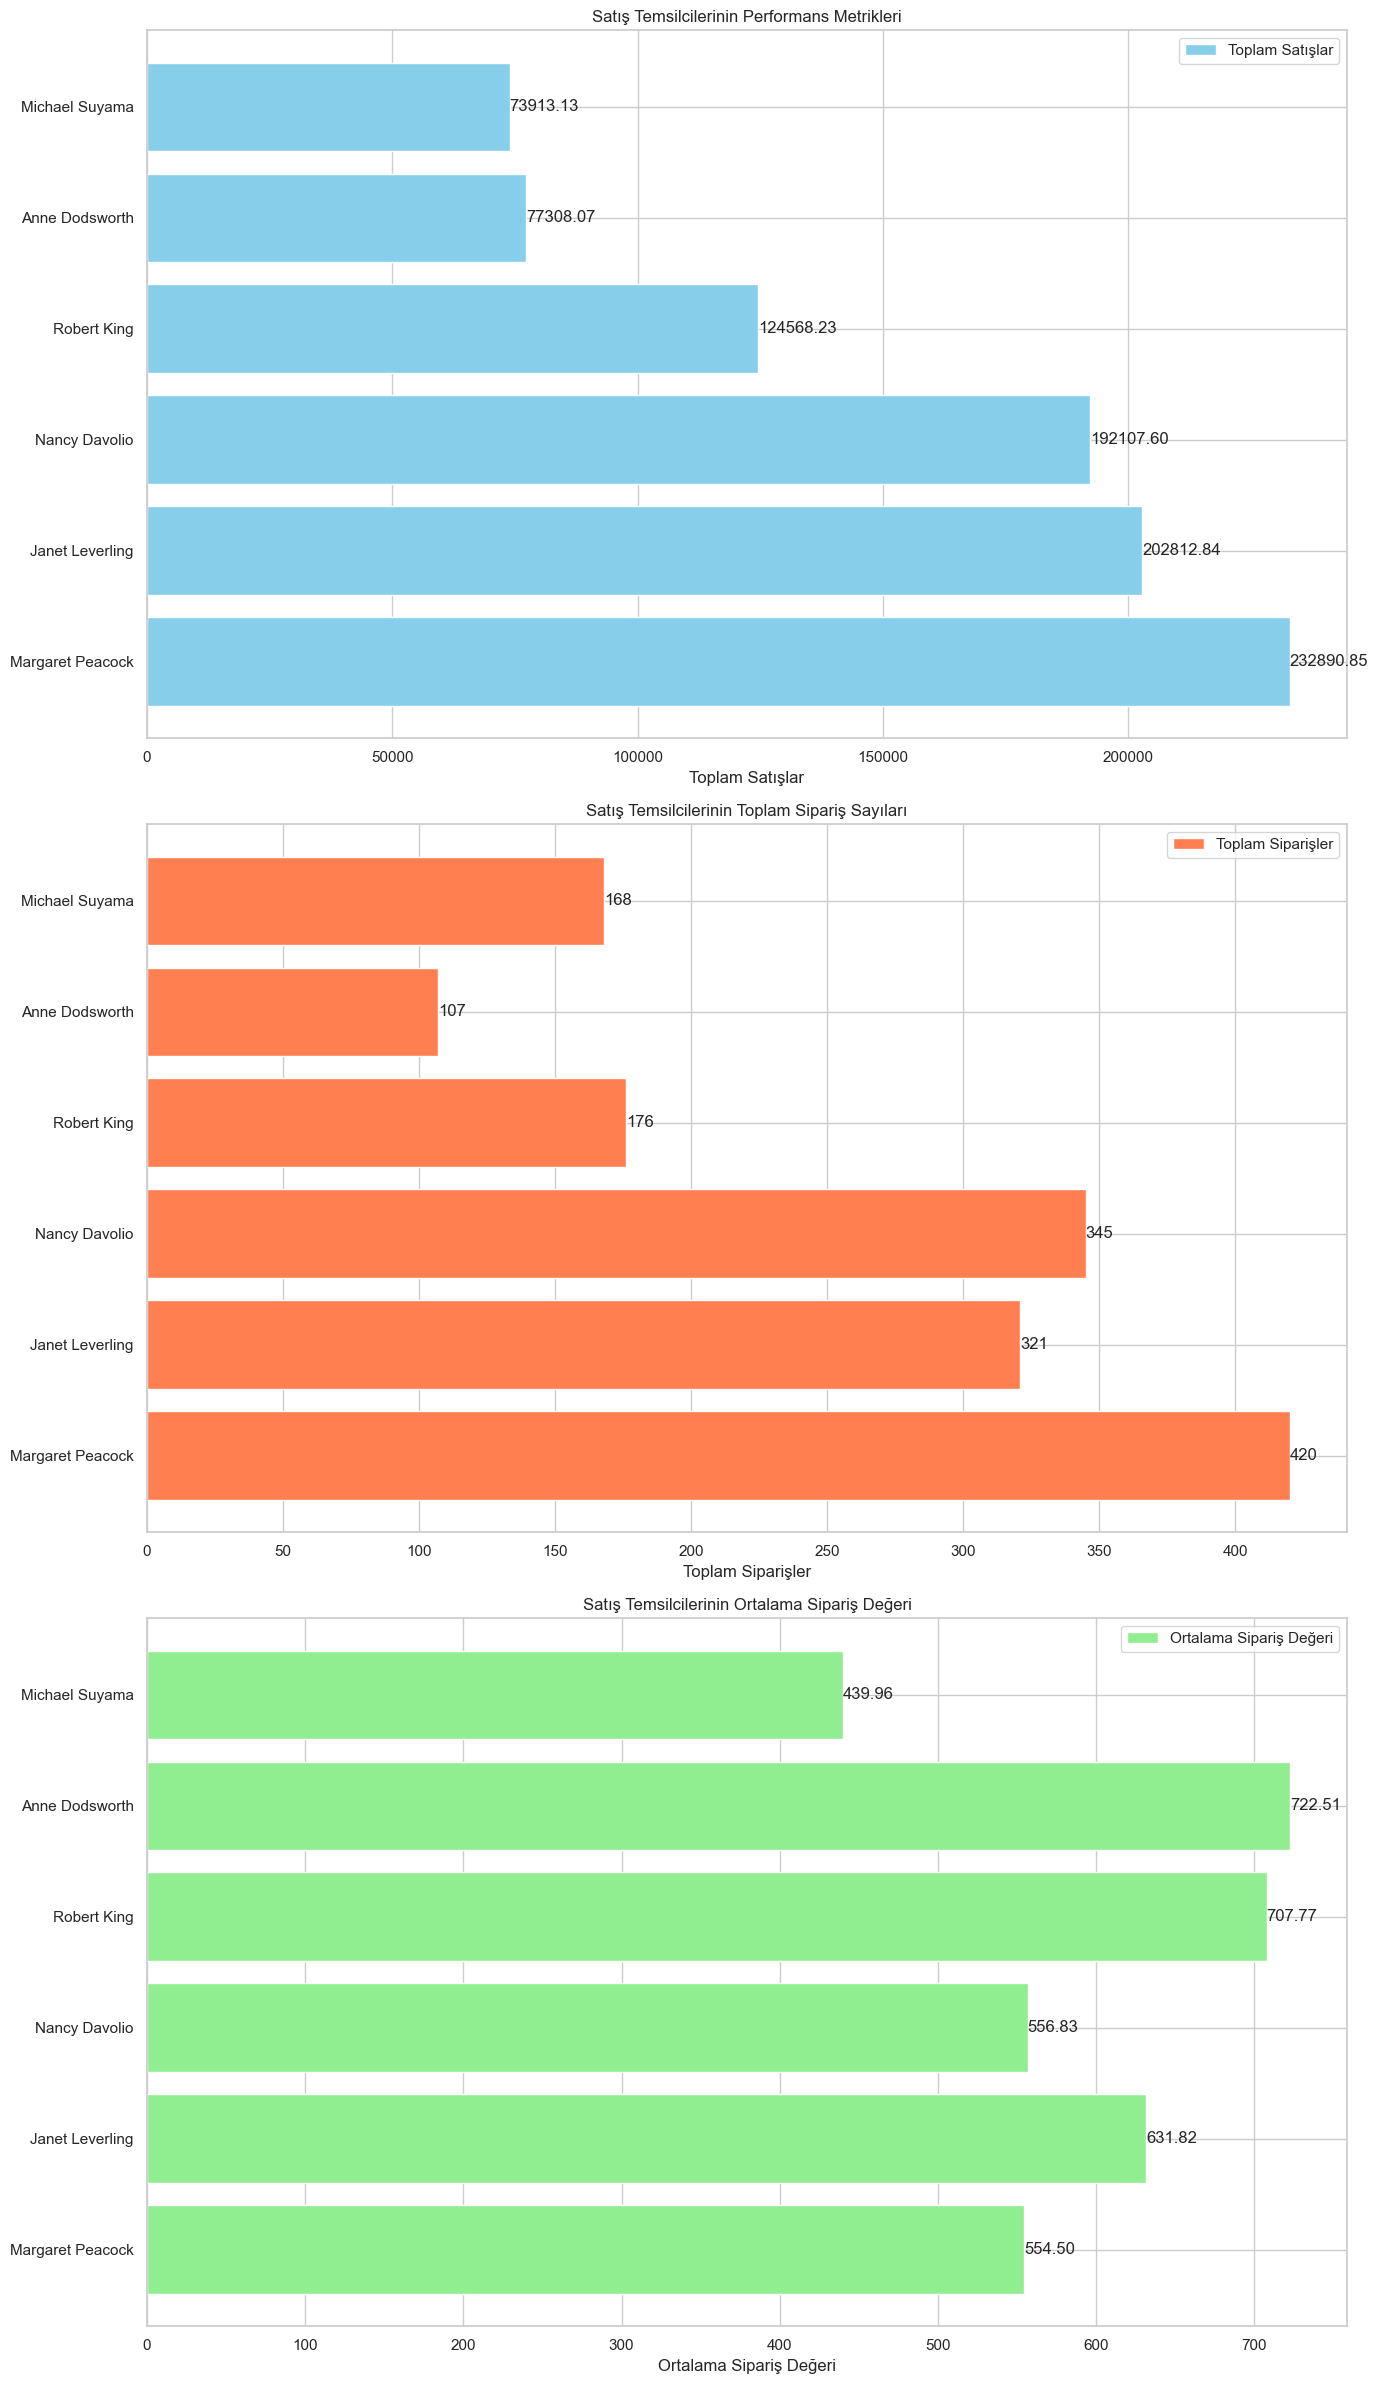

In [102]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

# Veritabanı bağlantısı için gerekli bilgiler
DB_HOST = 'localhost'
DB_PORT = '5432'
DB_NAME = 'capstone1'
DB_USER = 'postgres'
DB_PASS = 'Em030315'

# SQLAlchemy engine oluşturma
database_uri = f'postgresql+psycopg2://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}'
engine = create_engine(database_uri)

# Veritabanından veriyi çekme
query = """
SELECT
    CONCAT(e.first_name, ' ', e.last_name) AS employee_name,
    SUM(od.unit_price * od.quantity * (1 - od.discount)) AS total_sales,
    COUNT(o.order_id) AS total_orders,
    AVG(od.unit_price * od.quantity * (1 - od.discount)) AS avg_order_value
FROM
    employees e
    JOIN orders o ON e.employee_id = o.employee_id
    JOIN order_details od ON o.order_id = od.order_id
WHERE
    e.title = 'Sales Representative'
GROUP BY
    e.first_name, e.last_name
ORDER BY
    total_sales DESC;
"""

# Sorguyu çalıştırma ve sonucu pandas DataFrame'e yükleme
with engine.connect() as conn:
    df = pd.read_sql_query(query, conn)

# Veriyi görselleştirme

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 24))

# Grafik 1: Toplam Satışlar
bars1 = ax1.barh(df['employee_name'], df['total_sales'], color='skyblue', label='Toplam Satışlar')
ax1.set_xlabel('Toplam Satışlar')
ax1.set_title('Satış Temsilcilerinin Performans Metrikleri')
ax1.legend(loc='upper right')

# Bar etiketleri
for bar in bars1:
    width = bar.get_width()
    ax1.text(width, bar.get_y() + bar.get_height()/2, f'{width:.2f}', va='center', ha='left')

# Grafik 2: Toplam Siparişler
bars2 = ax2.barh(df['employee_name'], df['total_orders'], color='coral', label='Toplam Siparişler')
ax2.set_xlabel('Toplam Siparişler')
ax2.set_title('Satış Temsilcilerinin Toplam Sipariş Sayıları')
ax2.legend(loc='upper right')

# Bar etiketleri
for bar in bars2:
    width = bar.get_width()
    ax2.text(width, bar.get_y() + bar.get_height()/2, f'{width}', va='center', ha='left')

# Grafik 3: Ortalama Sipariş Değeri
bars3 = ax3.barh(df['employee_name'], df['avg_order_value'], color='lightgreen', label='Ortalama Sipariş Değeri')
ax3.set_xlabel('Ortalama Sipariş Değeri')
ax3.set_title('Satış Temsilcilerinin Ortalama Sipariş Değeri')
ax3.legend(loc='upper right')

# Bar etiketleri
for bar in bars3:
    width = bar.get_width()
    ax3.text(width, bar.get_y() + bar.get_height()/2, f'{width:.2f}', va='center', ha='left')

plt.tight_layout()
plt.show()



In [104]:
print('''

Toplam Satış Gelirleri:Bu grafikte, satış temsilcilerinin toplam satışları gösteriliyor. 

Margaret Peacock, Janet Leverling ve Nancy Davolio, en yüksek toplam satış gelirine sahip satış temsilcileri olarak öne çıkmaktadır. 
Özellikle Margaret Peacock, diğer temsilcilerden belirgin şekilde yüksek bir toplam satış gelirine sahiptir.

İçgörü: Yüksek performans gösteren bu temsilciler, satış gelirlerini artırma konusunda stratejik yaklaşımlar uygulamaktadır. 
Bu temsilcilerin uyguladığı stratejiler diğer temsilcilerle paylaşılabilir ve eğitim programları düzenlenebilir.

Toplam Sipariş Sayıları:Bu grafikte, her bir satış temsilcisinin gerçekleştirdiği toplam sipariş sayıları gösteriliyor.

Nancy Davolio ve Janet Leverling, en yüksek toplam sipariş sayısına sahip satış temsilcileridir. Bu, müşteri etkileşimlerinde aktif olduklarını 
ve müşteri sadakati oluşturduklarını göstermektedir.

İçgörü: Yüksek sipariş sayısına sahip temsilciler, müşteri ilişkileri yönetiminde etkili olabilir. Bu temsilcilerin müşteri ilişkileri stratejileri 
incelenebilir ve tüm ekibe yayılabilir.

Ortalama Sipariş Değeri:

Robert King, Janet Leverling ve Nancy Davolio'nun ortalama sipariş değerleri diğer temsilcilerden daha yüksektir. Bu, bu temsilcilerin daha
büyük veya daha karlı siparişler aldığını göstermektedir.

İçgörü: Ortalama sipariş değeri yüksek olan temsilciler, müşterilere ek ürün veya hizmetler sunarak satışları artırma konusunda başarılı 
olabilir. 


Ödül Sistemi Önerileri
En Yüksek Toplam Satış Geliri Ödülü:

En yüksek toplam satış gelirine sahip temsilcilere aylık, üç aylık veya yıllık olarak ödüller verilebilir. Bu ödüller nakit primler, tatil
paketleri veya değerli hediyeler şeklinde olabilir.

En Yüksek Sipariş Sayısı Ödülü:

En fazla sipariş sayısına ulaşan temsilcilere özel ödüller verilebilir.Örneğin, bir alışveriş çeki veya ek tatil günü.
Bu ödüller, müşteri sadakati ve etkileşimini artırdığı için önemlidir.

Ortalama Sipariş Değeri Ödülü:

Ortalama Sipariş Değeri en yüksek olan temsilcilere verilebilir.Örneğin, bir performans bonusu veya profesyonel gelişim eğitimi.Bu ödüller, 
temsilcilerin daha karlı satışlar yapma konusundaki başarılarını teşvik eder.

Performans Artış Ödülleri:
Önceki dönemlere göre performansını en çok artıran temsilcilere özel ödüller verilebilir. Bu, tüm temsilcilerin sürekli olarak kendilerini
geliştirmelerini teşvik eder.Yada En düşük performansa sahip temsilcilerin belirli bir hedefi aşmaları durumunda alacakları bir ödül verilebilir.
Bu, genel performansı artırmak için alt düzey temsilcileri motive eder. Örneğin, ek bir eğitim programı veya mentorluk fırsatları.

Sonuç:Bu analiz ve öneriler, satış temsilcilerinin motivasyonunu artırabilir, performanslarını ödüllendirir ve genel şirket verimliliğini artırabilir.''')





Toplam Satış Gelirleri:Bu grafikte, satış temsilcilerinin toplam satışları gösteriliyor. 

Margaret Peacock, Janet Leverling ve Nancy Davolio, en yüksek toplam satış gelirine sahip satış temsilcileri olarak öne çıkmaktadır. 
Özellikle Margaret Peacock, diğer temsilcilerden belirgin şekilde yüksek bir toplam satış gelirine sahiptir.

İçgörü: Yüksek performans gösteren bu temsilciler, satış gelirlerini artırma konusunda stratejik yaklaşımlar uygulamaktadır. 
Bu temsilcilerin uyguladığı stratejiler diğer temsilcilerle paylaşılabilir ve eğitim programları düzenlenebilir.

Toplam Sipariş Sayıları:Bu grafikte, her bir satış temsilcisinin gerçekleştirdiği toplam sipariş sayıları gösteriliyor.

Nancy Davolio ve Janet Leverling, en yüksek toplam sipariş sayısına sahip satış temsilcileridir. Bu, müşteri etkileşimlerinde aktif olduklarını 
ve müşteri sadakati oluşturduklarını göstermektedir.

İçgörü: Yüksek sipariş sayısına sahip temsilciler, müşteri ilişkileri yönetiminde etkili olabilir. Bu t

In [188]:
import pandas as pd
import sqlalchemy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Veritabanı bağlantısı kurma
DB_HOST = 'localhost'
DB_PORT = '5432'
DB_NAME = 'capstone1'
DB_USER = 'postgres'
DB_PASS = 'Em030315'

database_url = f"postgresql://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
engine = sqlalchemy.create_engine(database_url)

# SQL sorgusu ile verileri çekme ve toplam geliri hesaplama
query = """
SELECT 
    o.customer_id,
    o.order_date,
    od.unit_price,
    od.quantity,
    od.discount
FROM 
    orders o
JOIN
    order_details od ON o.order_id = od.order_id
"""

df = pd.read_sql(query, engine)

# Toplam geliri hesaplama
df['total_amount'] = df['unit_price'] * df['quantity'] * (1 - df['discount'])

# Veritabanından çekilen veriyi kontrol edin
print(df.head())

# Recency, Frequency ve Monetary değerlerini hesaplamak için veri setini genişletelim
df['order_date'] = pd.to_datetime(df['order_date'])

# En erken ve en geç sipariş tarihlerini belirleyin
min_date = df['order_date'].min()
max_date = df['order_date'].max()

# Recency, Frequency ve Monetary değerlerini hesaplayın
df_rfm = df.groupby('customer_id').agg(
    Recency=('order_date', lambda x: (max_date - x.max()).days),
    Frequency=('order_date', 'count'),
    Monetary=('total_amount', 'sum')
).reset_index()

# RFM skorlarını hesaplayın
df_rfm['R_rank'] = pd.qcut(df_rfm['Recency'], 4, labels=['4', '3', '2', '1'])
df_rfm['F_rank'] = pd.qcut(df_rfm['Frequency'], 4, labels=['1', '2', '3', '4'])
df_rfm['M_rank'] = pd.qcut(df_rfm['Monetary'], 4, labels=['1', '2', '3', '4'])

# RFM skoru oluşturun
df_rfm['RFM_Score'] = df_rfm.R_rank.astype(str) + df_rfm.F_rank.astype(str) + df_rfm.M_rank.astype(str)

# RFM segmentasyon fonksiyonu
def rfm_segment(df):
    if df['RFM_Score'] == '111':
        return 'Champions'
    elif df['RFM_Score'].startswith('1'):
        return 'Loyal Customers'
    elif df['RFM_Score'].startswith('2'):
        return 'Potential Loyalist'
    elif df['RFM_Score'].startswith('3'):
        return 'Need Attention'
    elif df['RFM_Score'].startswith('4'):
        return 'At Risk'
    else:
        return 'Others'

df_rfm['Segment'] = df_rfm.apply(rfm_segment, axis=1)

# Sonuçları görüntüleyin
print(df_rfm)




  customer_id  order_date  unit_price  quantity  discount  total_amount
0       VINET  1996-07-04        14.0        12       0.0         168.0
1       VINET  1996-07-04         9.8        10       0.0          98.0
2       VINET  1996-07-04        34.8         5       0.0         174.0
3       TOMSP  1996-07-05        18.6         9       0.0         167.4
4       TOMSP  1996-07-05        42.4        40       0.0        1696.0
   customer_id  Recency  Frequency    Monetary R_rank F_rank M_rank RFM_Score  \
0        ALFKI       27         12   4273.0000      2      2      2       222   
1        ANATR       63         10   1402.9500      1      1      1       111   
2        ANTON       98         17   7023.9775      1      2      2       122   
3        AROUT       26         30  13390.6500      2      3      3       233   
4        BERGS       63         52  24927.5775      1      4      4       144   
..         ...      ...        ...         ...    ...    ...    ...       ...   
8

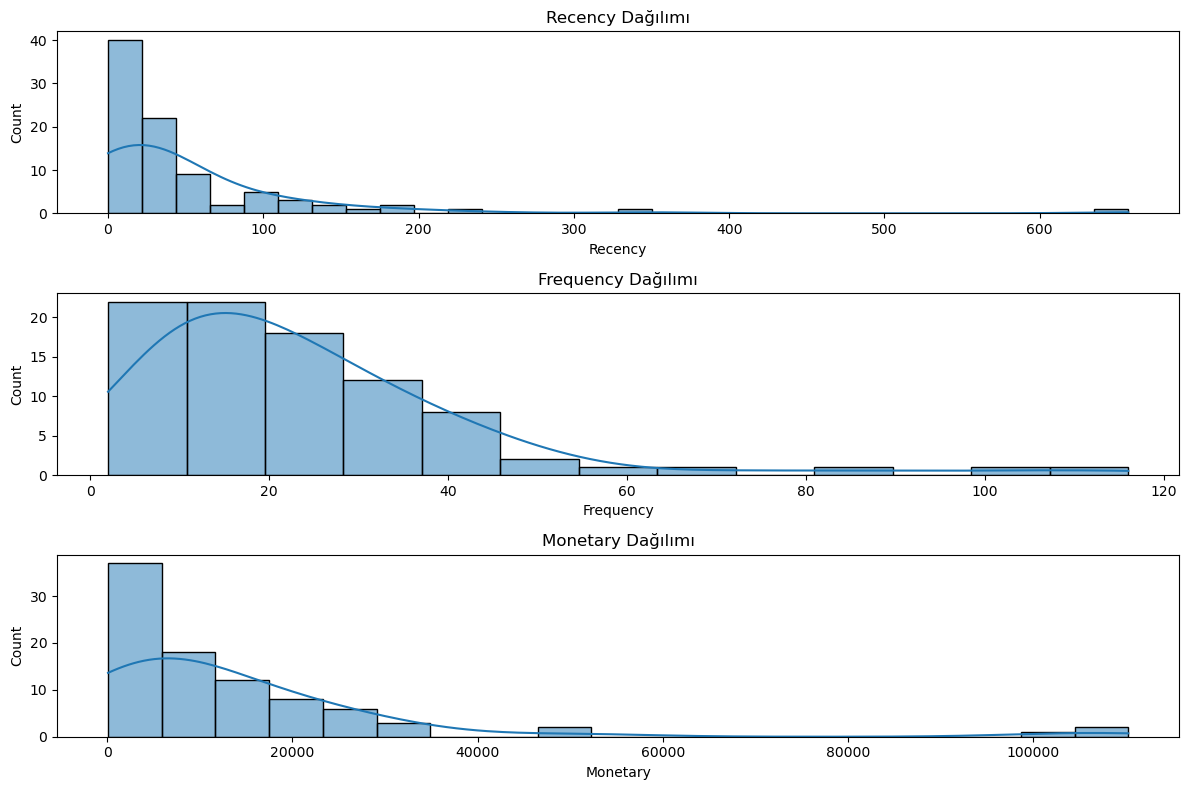

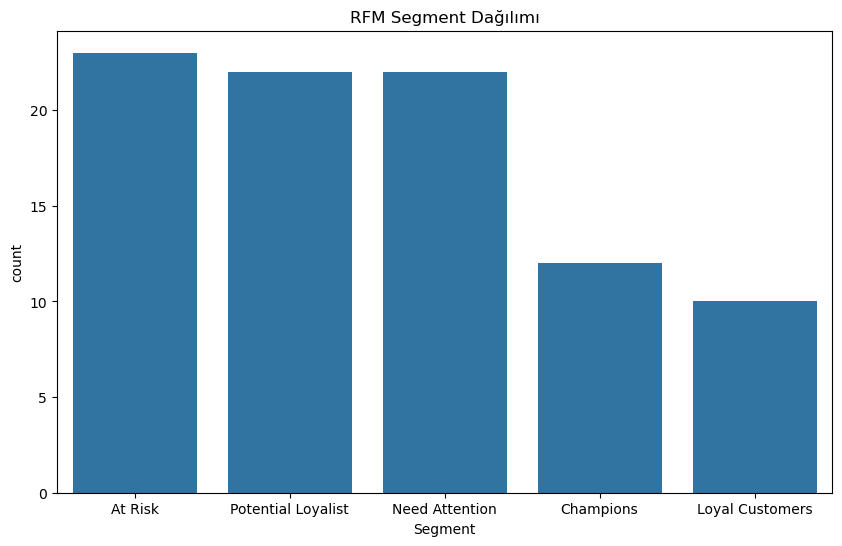

In [186]:
# RFM Analizini Görselleştirme
plt.figure(figsize=(12, 8))

# Recency dağılımı
plt.subplot(3, 1, 1)
sns.histplot(df_rfm['Recency'], kde=True)
plt.title('Recency Dağılımı')

# Frequency dağılımı
plt.subplot(3, 1, 2)
sns.histplot(df_rfm['Frequency'], kde=True)
plt.title('Frequency Dağılımı')

# Monetary dağılımı
plt.subplot(3, 1, 3)
sns.histplot(df_rfm['Monetary'], kde=True)
plt.title('Monetary Dağılımı')

plt.tight_layout()
plt.show()

# Segmentlere göre dağılım
plt.figure(figsize=(10, 6))
sns.countplot(x='Segment', data=df_rfm, order=df_rfm['Segment'].value_counts().index)
plt.title('RFM Segment Dağılımı')
plt.show()

In [108]:
print('''RFM Analizi Grafikleri ve İçgörüler
RFM analizi (Recency, Frequency, Monetary) müşteri segmentasyonu yapmak için kullanılan etkili bir yöntemdir. Bu analiz, müşterilerin son satın 
alma zamanları (Recency), satın alma sıklıkları (Frequency) ve toplam harcama miktarları (Monetary) üzerinden segmentlere ayrılmasını sağlar. 
Aşağıda bu analiz sonucunda elde edilen grafikler ve içgörüler bulunmaktadır.

Recency Dağılımı

Yorum: Müşterilerin büyük bir kısmı son zamanlarda satın alma yapmış. Bu, müşteri kitlesinin aktif olduğunu gösterir. Ancak, 100 gün ve üzeri 
süreyle alışveriş yapmamış müşteri sayısı da göz ardı edilmemelidir.
İçgörü: Daha önce alışveriş yapmış ancak son zamanlarda aktif olmayan müşterilere yeniden etkileşim kampanyaları düzenlenebilir.

Frequency Dağılımı

Yorum: Müşterilerin çoğu düşük sıklıkta alışveriş yapmış, ancak birkaç müşteri oldukça sık alışveriş yapmış.
İçgörü: Sık alışveriş yapan müşterilere sadakat programları ve özel indirimler sunularak bu davranışın devam etmesi teşvik edilebilir. Daha az 
sıklıkta alışveriş yapan müşteriler ise daha fazla alışveriş yapmaları için teşvik edilebilir.

Monetary Dağılımı

Yorum: Müşterilerin büyük çoğunluğu düşük harcamalar yapmış, ancak az sayıda müşteri yüksek harcamalar yapmış.
İçgörü: Yüksek harcama yapan müşteriler için özel VIP programları ve ayrıcalıklar sunularak müşteri bağlılığı artırılabilir. Düşük harcama yapan 
müşterilere çapraz satış ve yukarı satış (upsell) stratejileri uygulanabilir.

RFM Segment Dağılımı

Yorum: Müşteriler çeşitli segmentlere ayrılmış durumda. En fazla sayıda müşteri "At Risk" segmentinde bulunuyor, ardından "Potential Loyalist"
ve "Need Attention" segmentleri geliyor.

İçgörü:
At Risk: Bu segmentteki müşteriler kaybedilme riski altında. Bu müşterilere özel teklifler ve hatırlatıcı e-postalar gönderilerek yeniden 
kazanılmaya çalışılmalıdır.

Potential Loyalist: Bu müşteriler sadık olma potansiyeli taşıyor. Sadakat programları ve özel indirimlerle bu müşterilerin sadakatleri artırılabilir.

Need Attention: Bu müşteriler dikkat gerektiriyor. Onlarla iletişime geçerek memnuniyetlerini artırmak ve daha sık alışveriş yapmalarını sağlamak 
önemlidir.

Champions ve Loyal Customers: Bu müşteriler zaten markaya sadık ve yüksek değer taşıyor. Onları elde tutmak için sürekli olarak kaliteli hizmet 
ve özel fırsatlar sunulmalıdır.

Müşteri Segmentasyonu İçin Öneriler

Sadakat Programları: Sık alışveriş yapan ve yüksek harcama yapan müşteriler için özel sadakat programları oluşturulabilir.

Yeniden Etkileşim Kampanyaları: Son zamanlarda alışveriş yapmamış müşterilere özel yeniden etkileşim kampanyaları düzenlenebilir.

Kişiselleştirilmiş Pazarlama: Müşterilerin alışveriş davranışlarına göre kişiselleştirilmiş pazarlama stratejileri geliştirilebilir.

Özel İndirim ve Promosyonlar: Farklı segmentlerdeki müşteriler için özel indirim ve promosyonlar sunulabilir.

Bu analizler ve içgörüler, müşteri segmentasyonunu etkili bir şekilde kullanarak pazarlama stratejilerini optimize etmenize yardımcı olabilir.''')

RFM Analizi Grafikleri ve İçgörüler
RFM analizi (Recency, Frequency, Monetary) müşteri segmentasyonu yapmak için kullanılan etkili bir yöntemdir. Bu analiz, müşterilerin son satın 
alma zamanları (Recency), satın alma sıklıkları (Frequency) ve toplam harcama miktarları (Monetary) üzerinden segmentlere ayrılmasını sağlar. 
Aşağıda bu analiz sonucunda elde edilen grafikler ve içgörüler bulunmaktadır.

Recency Dağılımı

Yorum: Müşterilerin büyük bir kısmı son zamanlarda satın alma yapmış. Bu, müşteri kitlesinin aktif olduğunu gösterir. Ancak, 100 gün ve üzeri 
süreyle alışveriş yapmamış müşteri sayısı da göz ardı edilmemelidir.
İçgörü: Daha önce alışveriş yapmış ancak son zamanlarda aktif olmayan müşterilere yeniden etkileşim kampanyaları düzenlenebilir.

Frequency Dağılımı

Yorum: Müşterilerin çoğu düşük sıklıkta alışveriş yapmış, ancak birkaç müşteri oldukça sık alışveriş yapmış.
İçgörü: Sık alışveriş yapan müşterilere sadakat programları ve özel indirimler sunularak bu davranışın devam